# Plot XRD Patterns as a Heat Map sorted by relative Sn Composition

This notebook downloads all data and plots XRD heat maps. This notebook supports the publication:

An Inter-Laboratory Comparative High Throughput Experimental Study of Zn-Sn-Ti-O Thin Films

J. R. Hattrick-Simpers<sup>1</sup>, A. Zakutayev<sup>2</sup>, S. C. Barron<sup>1</sup>, Z. T. Trautt<sup>1</sup>, N. Nguyen<sup>1</sup>, K. Choudhary<sup>1</sup>, B. DeCost<sup>1</sup>, C. Phillips<sup>2</sup>, A. G. Kusne<sup>1</sup>, F. Yi<sup>1</sup>, A. Mehta<sup>3</sup>, I. Takeuchi<sup>4</sup>, J. D.Perkins<sup>2</sup>, M. L. Green<sup>1</sup>

1. National Institute of Standards and Technology (NIST), Gaithersburg, MD

1. National Renewable Energy Laboratory (NREL), Golden, CO

1. SLAC National Accelerator Laboratory, Menlo Park, CA

1. University of Maryland, College Park, MD

Contact: [htems@nist.gov](mailto:htems@nist.gov)

# Imports and Functions

In [1]:
import requests
requests.packages.urllib3.disable_warnings()
import json
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def check_response(r,quiet=False):
    try:
        r_content = r.json(object_pairs_hook=OrderedDict)
    except:
        r_content = r.text
    if str(r.status_code)[0] is not "2":
        if not quiet: print("Error: ",r.status_code) 
        if not quiet: print(r.text)
    else:
        return r_content

In [3]:
def mdcs_query(host,query,format='json'):
    url = host.strip("/") + "/rest/explore/query-by-example"
    data = dict()
    data['query'] = query
    data['dataformat'] = format
    r = requests.post(url, data=data, verify=False) # This needs to be fixed
    return check_response(r)

# Get the data

In [4]:
host = "https://hte.registry.nist.gov/"

In [5]:
libraries = dict()
flip = {'a':'b','b':'a'}
library_pairs = dict()

query = '{"content.project.identifier.id":"20.500.12048/proj.2015.1"}'
query_response = mdcs_query(host,query)
project = query_response[0]['content']['project']
library_registry = project['library']

for lib in library_registry:
    lib_id = lib['identifier']['id']
    query = '{"content.library.identifier.id":"'+lib_id+'"}'
    query_response = mdcs_query(host,query)
    library = query_response[0]['content']['library']
    lib_name = library['name']
    libraries[lib_id] = library
    num_samples = len(library['sample'])
    comment = library['comment']
    if 'NIST' in comment:
        nist_id = lib_id
        end_char = nist_id[-1]
        nrel_id = nist_id[0:-1]+flip[end_char]
        library_pairs[nist_id] = nrel_id
    #print("_"*50)
    #print("Library Name:",lib_name)
    #print("Library Handle:",lib_id)
    #print("Number of Samples:",num_samples)
    #print("Comment:",comment)

print(library_pairs)

{'20.500.12048/lib.2015.1a': '20.500.12048/lib.2015.1b', '20.500.12048/lib.2016.1b': '20.500.12048/lib.2016.1a', '20.500.12048/lib.2016.2b': '20.500.12048/lib.2016.2a', '20.500.12048/lib.2016.3b': '20.500.12048/lib.2016.3a'}


# Begin Band Gap Figues

In [6]:
band_gap = dict()
for lib_id,lib in libraries.items():
    band_gap[lib_id] = [-1.0] * len(lib['sample'])
    for sample in lib['sample']:
        s_id = sample['identifier'][1]['id'] -1
        bg = sample['property'][3]['value']
        band_gap[lib_id][s_id] = bg

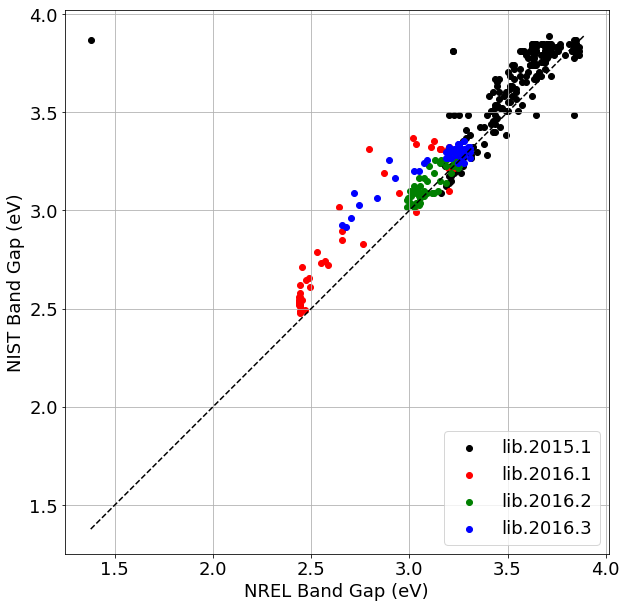

In [7]:
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
i = 0
lower_list = list()
upper_list = list()
for nist_id,nrel_id in library_pairs.items():
    this_lower = min([min(band_gap[nrel_id]),min(band_gap[nist_id])])
    this_upper = max([max(band_gap[nrel_id]),max(band_gap[nist_id])])
    lower_list.append(this_lower)
    upper_list.append(this_upper)
    plt.scatter(band_gap[nrel_id],band_gap[nist_id],c=colors[i], label = nist_id.split('/')[1][0:-1])
    i = i+1

lower = min(lower_list)
upper = max(upper_list)
plt.plot([lower,upper],[lower,upper],'k--')
plt.legend()
plt.axes().set_aspect('equal')
ax = plt.axes()
plt.xlabel('NREL Band Gap (eV)')
plt.ylabel('NIST Band Gap (eV)')
plt.grid(True)
plt.show()

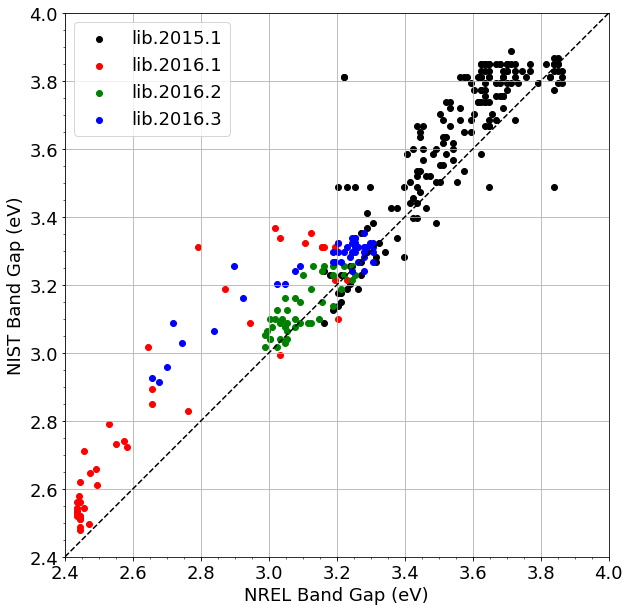

In [8]:
major = 0.2
minor = 0.05
lower = 2.4
upper = 4.0
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)

plt.figure(figsize=(10,10))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(major))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor))
ax.yaxis.set_major_locator(ticker.MultipleLocator(major))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(minor))
plt.grid(True)
i = 0
for nist_id,nrel_id in library_pairs.items():
    plt.scatter(band_gap[nrel_id],band_gap[nist_id],c=colors[i], label = nist_id.split('/')[1][0:-1])
    i = i+1

plt.plot([lower,upper],[lower,upper],'k--')
plt.legend()
plt.axes().set_aspect('equal')
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.xlabel('NREL Band Gap (eV)')
plt.ylabel('NIST Band Gap (eV)')
plt.savefig("band-gap.pdf", bbox_inches='tight')
plt.show()


# Begin Thickness Figures

In [9]:
thickness = dict()
for lib_id,lib in libraries.items():
    thickness[lib_id] = [-1.0] * len(lib['sample'])
    for sample in lib['sample']:
        s_id = sample['identifier'][1]['id'] -1
        z = sample['property'][0]['value']
        thickness[lib_id][s_id] = z

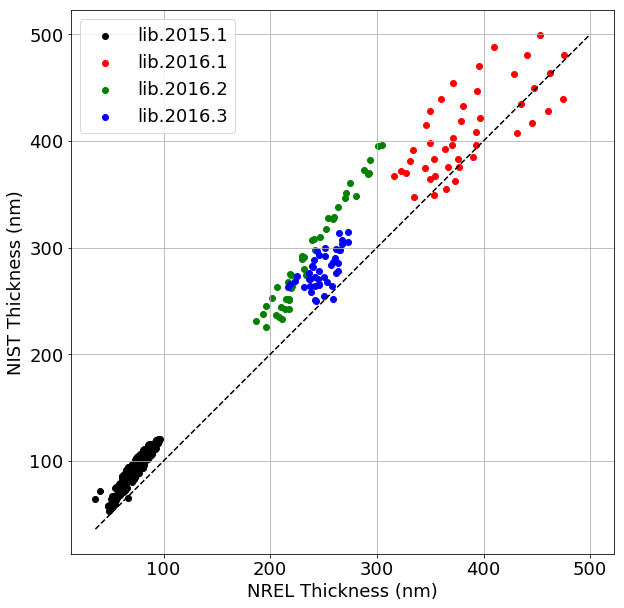

In [10]:
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
i = 0
lower_list = list()
upper_list = list()
for nist_id,nrel_id in library_pairs.items():
    this_lower = min([min(thickness[nrel_id]),min(thickness[nist_id])])
    this_upper = max([max(thickness[nrel_id]),max(thickness[nist_id])])
    lower_list.append(this_lower)
    upper_list.append(this_upper)
    plt.scatter(thickness[nrel_id],thickness[nist_id],c=colors[i], label = nist_id.split('/')[1][0:-1])
    i = i+1

lower = min(lower_list)
upper = max(upper_list)
plt.plot([lower,upper],[lower,upper],'k--')
plt.legend()
plt.axes().set_aspect('equal')
ax = plt.axes()
plt.xlabel('NREL Thickness (nm)')
plt.ylabel('NIST Thickness (nm)')
plt.grid(True)
plt.savefig("thickness.pdf", bbox_inches='tight')
plt.show()

# Begin Conductivity Figure

In [11]:
cond = dict()
for lib_id,lib in libraries.items():
    cond[lib_id] = [10**(-10)] * len(lib['sample'])
    for sample in lib['sample']:
        s_id = sample['identifier'][1]['id'] -1
        try: 
            z = sample['property'][1]['value']
            cond[lib_id][s_id] = z
        except:
            pass

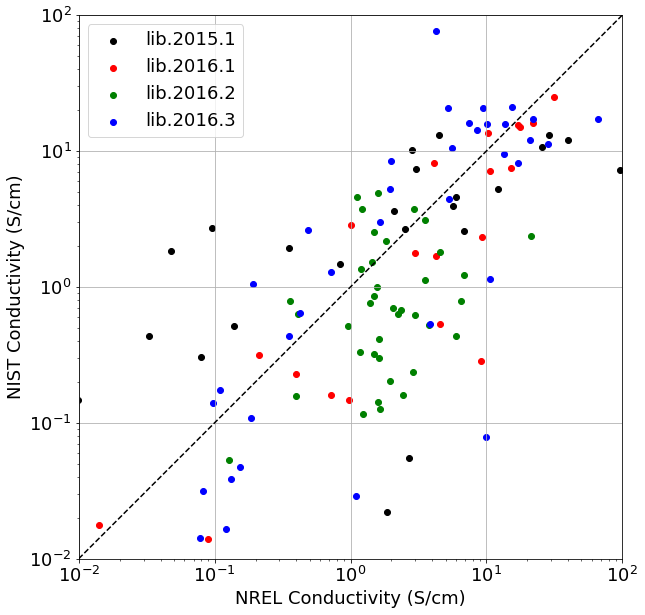

In [12]:
lower = 10**-2
upper = 10**2
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
i = 0

for nist_id,nrel_id in library_pairs.items():
    plt.scatter(cond[nrel_id],cond[nist_id],c=colors[i], label = nist_id.split('/')[1][0:-1])
    i = i+1

plt.plot([lower,upper],[lower,upper],'k--')
plt.legend()
plt.axes().set_aspect('equal')
ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.xlabel('NREL Conductivity (S/cm)')
plt.ylabel('NIST Conductivity (S/cm)')
plt.grid(True)
plt.savefig("conductivity.pdf", bbox_inches='tight')
plt.show()

# Begin Sheet Resistance Figure

In [13]:
sheet = dict()
for lib_id,lib in libraries.items():
    sheet[lib_id] = [1.0] * len(lib['sample'])
    for sample in lib['sample']:
        s_id = sample['identifier'][1]['id'] -1
        try: 
            z = sample['property'][2]['value']
            sheet[lib_id][s_id] = z
        except:
            pass

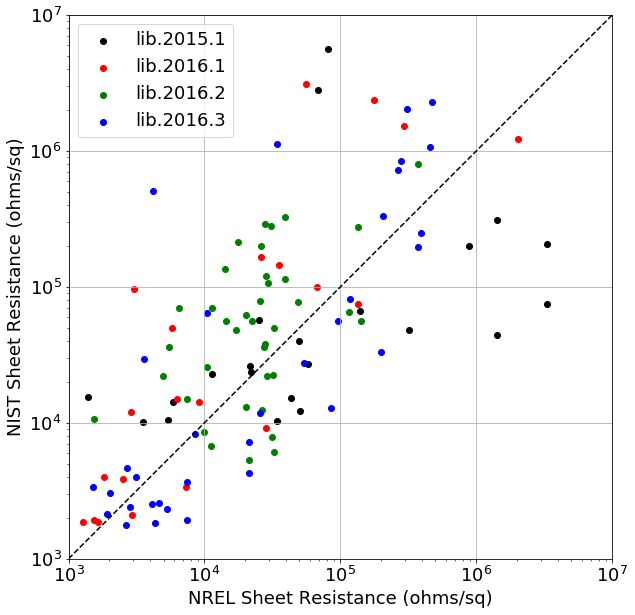

In [14]:
lower = 10**3
upper = 10**7
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
i = 0

for nist_id,nrel_id in library_pairs.items():
    plt.scatter(sheet[nrel_id],sheet[nist_id],c=colors[i], label = nist_id.split('/')[1][0:-1])
    i = i+1

plt.plot([lower,upper],[lower,upper],'k--')
plt.legend()
plt.axes().set_aspect('equal')
ax = plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.xlabel('NREL Sheet Resistance (ohms/sq)')
plt.ylabel('NIST Sheet Resistance (ohms/sq)')
plt.grid(True)
plt.savefig("sheet-resistance.pdf", bbox_inches='tight')
plt.show()

# Begin Zn Figure NIST Library

In [15]:
comp = dict()
for lib_id,lib in libraries.items():
    comp[lib_id] = [0.0] * len(lib['sample'])
    for sample in lib['sample']:
        s_id = sample['identifier'][1]['id'] -1
        try: 
            z = sample['composition']['constituent'][0]['quantity']
            comp[lib_id][s_id] = z
        except:
            pass

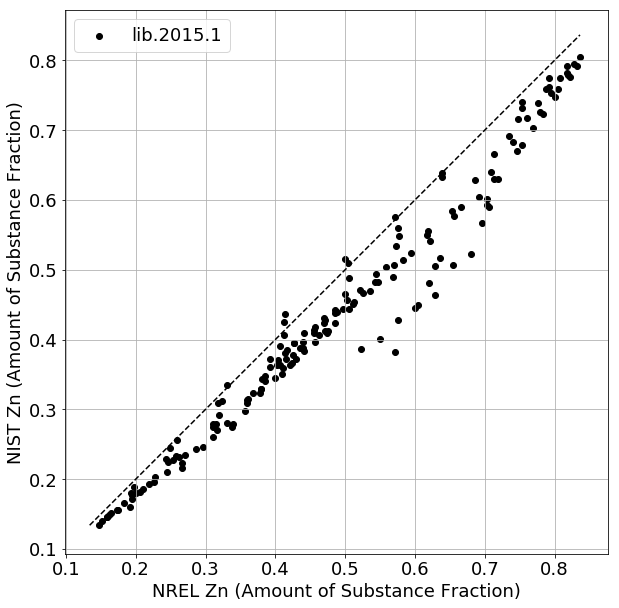

In [16]:
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
i = 0
lower_list = list()
upper_list = list()
for nist_id,nrel_id in library_pairs.items():
    if '2016' in nist_id: continue
    this_lower = min([min(comp[nrel_id]),min(comp[nist_id])])
    this_upper = max([max(comp[nrel_id]),max(comp[nist_id])])
    lower_list.append(this_lower)
    upper_list.append(this_upper)
    plt.scatter(comp[nrel_id],comp[nist_id],c=colors[i], label = nist_id.split('/')[1][0:-1])
    i = i+1

lower = min(lower_list)
upper = max(upper_list)
plt.plot([lower,upper],[lower,upper],'k--')
plt.legend()
plt.axes().set_aspect('equal')
ax = plt.axes()
plt.xlabel('NREL Zn (Amount of Substance Fraction)')
plt.ylabel('NIST Zn (Amount of Substance Fraction)')
plt.grid(True)
plt.savefig("composition-Zn.pdf", bbox_inches='tight')
plt.show()

# Begin Sn Figure NIST Library

In [17]:
comp = dict()
for lib_id,lib in libraries.items():
    comp[lib_id] = [0.0] * len(lib['sample'])
    for sample in lib['sample']:
        s_id = sample['identifier'][1]['id'] -1
        try: 
            z = sample['composition']['constituent'][1]['quantity']
            comp[lib_id][s_id] = z
        except:
            pass

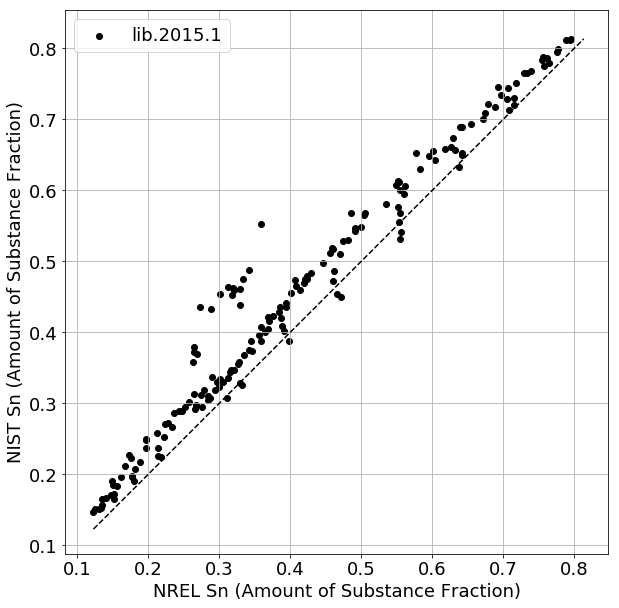

In [18]:
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
i = 0
lower_list = list()
upper_list = list()
for nist_id,nrel_id in library_pairs.items():
    if '2016' in nist_id: continue
    this_lower = min([min(comp[nrel_id]),min(comp[nist_id])])
    this_upper = max([max(comp[nrel_id]),max(comp[nist_id])])
    lower_list.append(this_lower)
    upper_list.append(this_upper)
    plt.scatter(comp[nrel_id],comp[nist_id],c=colors[i], label = nist_id.split('/')[1][0:-1])
    i = i+1

lower = min(lower_list)
upper = max(upper_list)
plt.plot([lower,upper],[lower,upper],'k--')
plt.legend()
plt.axes().set_aspect('equal')
ax = plt.axes()
plt.xlabel('NREL Sn (Amount of Substance Fraction)')
plt.ylabel('NIST Sn (Amount of Substance Fraction)')
plt.grid(True)
plt.savefig("composition-Sn.pdf", bbox_inches='tight')
plt.show()

# Begin Ti Figure NIST Library

In [19]:
comp = dict()
for lib_id,lib in libraries.items():
    comp[lib_id] = [0.0] * len(lib['sample'])
    for sample in lib['sample']:
        s_id = sample['identifier'][1]['id'] -1
        try: 
            z = sample['composition']['constituent'][2]['quantity']
            comp[lib_id][s_id] = z
        except:
            pass

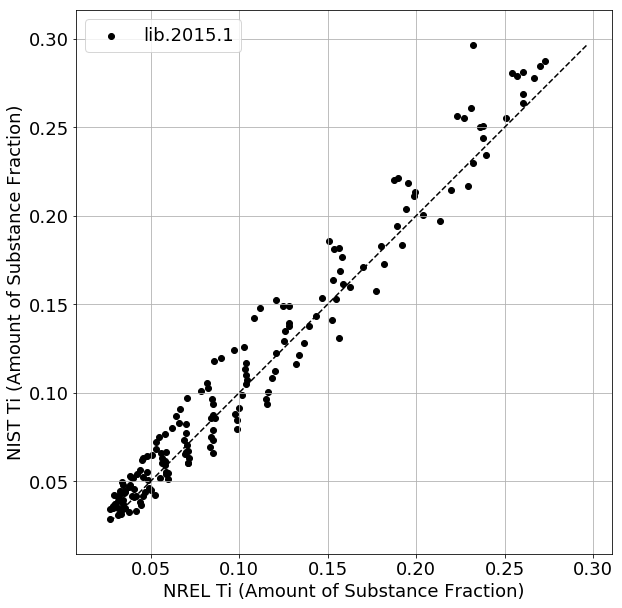

In [20]:
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
i = 0
lower_list = list()
upper_list = list()
for nist_id,nrel_id in library_pairs.items():
    if '2016' in nist_id: continue
    this_lower = min([min(comp[nrel_id]),min(comp[nist_id])])
    this_upper = max([max(comp[nrel_id]),max(comp[nist_id])])
    lower_list.append(this_lower)
    upper_list.append(this_upper)
    plt.scatter(comp[nrel_id],comp[nist_id],c=colors[i], label = nist_id.split('/')[1][0:-1])
    i = i+1

lower = min(lower_list)
upper = max(upper_list)
plt.plot([lower,upper],[lower,upper],'k--')
plt.legend()
plt.axes().set_aspect('equal')
ax = plt.axes()
plt.xlabel('NREL Ti (Amount of Substance Fraction)')
plt.ylabel('NIST Ti (Amount of Substance Fraction)')
plt.grid(True)
plt.savefig("composition-Ti.pdf", bbox_inches='tight')
plt.show()